In [ ]:
!pip install gplearn
!pip install optuna

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import optuna


from tensorflow.keras.layers import Dense, Dropout, LSTM, RNN, GRU, SimpleRNN, Conv1D, MaxPooling1D, Bidirectional, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from gplearn.genetic import SymbolicRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from math import nan
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
commbankdata = yf.download('CBA.AX', start='2015-01-01', end='2023-08-01')
commbankdata.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,84.959686,85.277962,84.661308,85.277962,53.524395,949439
2015-01-05,85.238182,85.775269,85.049202,85.486832,53.655495,1351651
2015-01-06,84.641411,85.337639,84.412651,84.840332,53.249722,2477275
2015-01-07,84.850281,85.029312,84.094376,84.651360,53.131115,2127190
2015-01-08,85.079041,85.188446,84.671249,84.929848,53.305904,1997761


In [ ]:
commbankdata.isnull().sum()

,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


In [ ]:
def sgpModel(data):
  # Define target variable as 'Close' column and features as all other columns
  y_data = data['Close']
  x_data = data.drop(columns=['Close'])

  x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

  # Initialize SymbolicRegressor model with specified parameters
  sgp_model = SymbolicRegressor(
      population_size=500,              # Number of individuals in each generation
      generations=20,                   # Number of generations to evolve
      stopping_criteria=0.01,           # Criteria to stop evolution early
      p_crossover=0.75,                 # Crossover probability
      p_subtree_mutation=0.1,           # Subtree mutation probability
      p_hoist_mutation=0.1,             # Hoist mutation probability
      p_point_mutation=0.05,            # Point mutation probability
      max_samples=0.9,                  # Fraction of training samples for model fitting
      verbose=1,                        # Print evolution progress
      parsimony_coefficient=0.01,       # Control complexity of solutions
      random_state=42,                  # Seed for reproducibility
      function_set=['add', 'sub', 'mul', 'div', 'log']  # Allowed functions for expressions
  )

  # Fit the SGP model to the training data
  sgp_model.fit(x_train, y_train)

  # Predict new features for both train and test sets
  new_feature_train = sgp_model.predict(x_train)
  new_feature_test = sgp_model.predict(x_test)

  # Print Mean Squared Error for train and test sets
  print('TrainMSE: ' + str(mean_squared_error(y_train, new_feature_train)))
  print('TestMSE: ' + str(mean_squared_error(y_test, new_feature_test)))

  # Retrieve the best symbolic expression from the fitted model
  best_expression = sgp_model._program

  # Print the best symbolic expression found
  print("Best symbolic expression:", best_expression)

  # Check feature importance based on frequency in the best expression
  feature_importance = {f"X{i}": 0 for i in range(x_train.shape[1])}
  expression_str = str(best_expression)  # Convert expression to string for analysis
  for i in range(x_train.shape[1]):
    feature_importance[f"X{i}"] = expression_str.count(f"X{i}")

  # Sort features by their importance (frequency in expression)
  sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
  print("Feature Importance:")
  for feature, importance in sorted_features:
    print(f"{feature}: {importance}")

  # Select the top N features based on importance
  top_n = 3  # Number of top features to retain
  selected_features = [int(f[1:]) for f, imp in sorted_features[:top_n] if imp > 0]

  # Return processed features and original train-test split data
  return new_feature_train, new_feature_test, x_train, x_test, y_train, y_test


In [ ]:
new_feature_train, new_feature_test, x_train, x_test, y_train, y_test = sgpModel(commbankdata)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    18.16      1.17843e+19        3         0.404923         0.466408     11.10s
   1    13.03      1.55203e+12        5         0.304432         0.281652     10.01s
   2     8.27       1.2013e+11        5         0.299723         0.323924      8.54s
   3     5.33      2.43025e+10        5         0.294783          0.36827      7.47s
   4     4.84      1.06193e+06        5         0.293875         0.376423      6.20s
   5     4.90           335074        5         0.295307         0.363566      6.13s
   6     5.12      4.61339e+07        5           0.2952         0.364526      5.71s
   7     5.06      1.77672e+09        5         0.296084         0.356597      5.05s
   8     5.03      4.32731e+07        5         0.293171         0.382747  

In [ ]:
new_x_train = np.concatenate((x_train, new_feature_train.reshape(-1, 1)), axis=1)
new_x_test = np.concatenate((x_test, new_feature_test.reshape(-1, 1)), axis=1)

In [ ]:
x_train_temp = pd.DataFrame(new_x_train)
x_train_temp.columns = ['Open', 'High', 'Low', 'Adj Close', 'Volume', 'New Features']

x_test_temp = pd.DataFrame(new_x_test)
x_test_temp.columns = ['Open', 'High', 'Low', 'Adj Close', 'Volume', 'New Features']

x_data_temp = pd.concat([x_train_temp, x_test_temp])
y_data_temp = pd.concat([y_train, y_test])

In [ ]:
x_data_temp = x_data_temp.reset_index(drop=True)
y_data_temp = y_data_temp.reset_index(drop=True)

enhance_data = pd.concat([x_data_temp, y_data_temp], axis=1)
enhance_data = pd.DataFrame(enhance_data)

new_column_order = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'New Features']

enhance_data = enhance_data[new_column_order]
enhance_data

,Open,High,Low,Close,Adj Close,Volume,New Features
0,82.500000,83.279999,82.099998,82.940002,59.236034,2325760.0,82.879997
1,85.079041,85.188446,84.671249,84.929848,53.305904,1997761.0,84.780655
2,69.849998,70.639999,69.510002,70.620003,54.977726,3533519.0,70.300003
3,71.010002,71.070000,70.500000,70.669998,56.559254,2086127.0,70.559998
4,83.089996,84.099998,83.010002,83.809998,59.857388,5554084.0,84.020004
...,...,...,...,...,...,...,...
2166,99.470001,100.000000,98.650002,99.779999,92.017654,2472383.0,99.180000
2167,71.660004,72.720001,71.260002,72.529999,50.601681,2374165.0,72.320000
2168,68.250000,68.379997,67.610001,68.110001,58.224327,3174818.0,67.739998
2169,86.169998,86.599998,85.470001,85.570000,74.439659,1559267.0,85.900002


In [ ]:
table1 = commbankdata.copy()
table2 = enhance_data.copy()

table1['New Features'] = nan

for idx1, row1 in table1.iterrows():
    # Create a mask of non-missing values in the row of Table 1, EXCLUDING 'New Features'
    non_missing_mask = row1[row1.index != 'New Features'].notna()

    # Filter Table 2 to match values in non-missing columns of Table 1
    common_cols = non_missing_mask.index.intersection(table2.columns)
    matching_rows = table2.loc[(table2[common_cols] == row1[common_cols].values).all(axis=1)]

    # If a matching row is found, fill in the missing values in Table 1
    if not matching_rows.empty:
        # Take the first match and fill the missing values
        for col in table1.columns:
            if pd.isna(row1[col]):  # Only fill missing values
                table1.at[idx1, col] = matching_rows.iloc[0][col]

In [ ]:
enhance_data = table1
enhance_data

,Open,High,Low,Close,Adj Close,Volume,New Features
Date,,,,,,,
2015-01-02,84.959686,85.277962,84.661308,85.277962,53.524395,949439,84.979584
2015-01-05,85.238182,85.775269,85.049202,85.486832,53.655495,1351651,85.586288
2015-01-06,84.641411,85.337639,84.412651,84.840332,53.249722,2477275,85.108879
2015-01-07,84.850281,85.029312,84.094376,84.651360,53.131115,2127190,84.273407
2015-01-08,85.079041,85.188446,84.671249,84.929848,53.305904,1997761,84.780655
...,...,...,...,...,...,...,...
2023-07-25,104.400002,104.400002,103.510002,104.199997,98.123543,1520910,103.510002
2023-07-26,103.930000,105.769997,103.669998,105.000000,98.876884,1631244,105.509995
2023-07-27,105.400002,107.089996,105.300003,106.529999,100.317665,2544987,106.989998


In [ ]:
def load_and_process_data(data, train_ratio=0.8, price_value='Close'):
    scalers = {}

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[price_value].values.reshape(-1, 1))
    scalers[price_value] = scaler

    PREDICTION_DAYS = 100
    scaled_data_train = []
    scaled_data_test = []

    scaled_data = scaled_data[:, 0]
    for x in range(PREDICTION_DAYS, len(scaled_data)):
        scaled_data_train.append(scaled_data[x - PREDICTION_DAYS:x])
        scaled_data_test.append(scaled_data[x])

    scaled_data_train = np.array(scaled_data_train)
    scaled_data_test = np.array(scaled_data_test)

    scaled_data_train = np.reshape(scaled_data_train, (scaled_data_train.shape[0], scaled_data_train.shape[1], 1))

    train_size = int(len(scaled_data_train) * train_ratio)
    x_train, x_test = scaled_data_train[:train_size], scaled_data_train[train_size:]
    y_train, y_test = scaled_data_test[:train_size], scaled_data_test[train_size:]


    return x_train, y_train, x_test, y_test, scalers, scaler

In [ ]:
enhance_x_train, enhance_y_train, enhance_x_test, enhance_y_test, scalers, scaler = load_and_process_data(
    data=enhance_data,
    price_value='Close',
    train_ratio=0.8
)

print(enhance_x_train.shape)
print(enhance_y_train.shape)
print(enhance_x_test.shape)
print(enhance_y_test.shape)

(1656, 100, 1)
(1656,)
(415, 100, 1)
(415,)


In [ ]:
x_train, y_train, x_test, y_test, scalers, scaler = load_and_process_data(
    data=commbankdata,
    price_value='Close',
    train_ratio=0.8
)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1656, 100, 1)
(1656,)
(415, 100, 1)
(415,)


In [ ]:
def lstm_model(x_train, y_train, model, epoch, batchSize, n_layers=4, dropout=0.2, units=[50,50,50,1], activations=['tanh', 'tanh', 'tanh', 'linear'], optimizer='adam', loss='mean_squared_error'):
  model.add(LSTM(units=units[0], return_sequences=True, activation=activations[0],input_shape=(x_train.shape[1], 1)))
  model.add(Dropout(dropout))

  for i in range(n_layers - 3):
    model.add(LSTM(units=units[i+1], return_sequences=True, activation=activations[i+1]))
    model.add(Dropout(dropout))

  model.add(LSTM(units=units[-2], activation=activations[-2]))
  model.add(Dropout(dropout))

  model.add(Dense(units=units[-1], activation=activations[-1]))

  model.compile(optimizer=optimizer, loss=loss)
  model.fit(x_train, y_train, epochs=epoch, batch_size=batchSize)

  return model

def gru_model(x_train, y_train, model, epoch, batchSize, n_layers=4, dropout=0.2, units=[50,50,50,50], activations=['tanh', 'tanh', 'tanh', 'linear'], optimizer='adam', loss='mean_squared_error'):
  model.add(GRU(units=units[0], return_sequences=True, activation=activations[0], input_shape=(x_train.shape[1], 1)))
  model.add(Dropout(dropout))


  for i in range(n_layers - 3):
    model.add(GRU(units=units[i+1], return_sequences=True, activation=activations[i+1]))
    model.add(Dropout(dropout))

  model.add(GRU(units=units[-2], activation=activations[-2]))
  model.add(Dropout(dropout))
  model.add(Dense(units=units[-1], activation=activations[-1]))

  model.compile(optimizer=optimizer, loss=loss)
  model.fit(x_train, y_train, epochs=epoch, batch_size=batchSize)
  return model

def rnn_model(x_train, y_train, model, epoch, batchSize, n_layers=4, dropout=0.2, units=[50,50,50,50], activations=['tanh', 'tanh', 'tanh', 'linear'], optimizer='adam', loss='mean_squared_error'):
    model.add(SimpleRNN(units=units[0], return_sequences=True, activation=activations[0], input_shape=(x_train.shape[1], 1)))
    model.add(Dropout(dropout))

    for i in range(n_layers - 3):
        model.add(SimpleRNN(units=units[i+1], return_sequences=True, activation=activations[i+1]))
        model.add(Dropout(dropout))

    model.add(SimpleRNN(units=units[-1], activation=activations[-2]))
    model.add(Dropout(dropout))
    model.add(Dense(units=1, activation=activations[-1]))

    model.compile(optimizer=optimizer, loss=loss)
    model.fit(x_train, y_train, epochs=epoch, batch_size=batchSize)

    return model


def model_load(x_train, y_train, modelName='LSTM', epoch=25, batchSize=32, layers=4, dropout=0.2, units=[50,50,50,1], activations=['tanh', 'tanh', 'tanh', 'linear'], optimizer='adam', loss='mean_squared_error'):
  model = Sequential()
  if layers != len(units) != len(activations):
    print('Number of layers and units and activation function do not match')
    return None

  if modelName == 'LSTM':
    return lstm_model(x_train, y_train, model, epoch, batchSize, layers, dropout, units, activations, optimizer, loss)
  elif modelName == 'GRU':
    return gru_model(x_train, y_train, model, epoch, batchSize, layers, dropout, units, activations, optimizer, loss)
  elif modelName == 'RNN':
    return rnn_model(x_train, y_train, model, epoch, batchSize, layers, dropout, units, activations, optimizer, loss)
  else:
    print('Invalid model name')
    return None


In [ ]:
sgp_lstm_model = model_load(enhance_x_train, enhance_y_train, 'LSTM', 25, 32, 4, 0.2, [128,64,32,1], ['relu', 'relu', 'relu','linear'], 'adam', 'mean_squared_error')

Epoch 1/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 222ms/step - loss: 0.0830
Epoch 2/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 221ms/step - loss: 0.0076
Epoch 3/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 224ms/step - loss: 0.0072
Epoch 4/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 224ms/step - loss: 0.0067
Epoch 5/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 216ms/step - loss: 0.0055
Epoch 6/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 223ms/step - loss: 0.0053
Epoch 7/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 206ms/step - loss: 0.0052
Epoch 8/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 220ms/step - loss: 0.0052
Epoch 9/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 13s 242ms/step - loss: 0.0045
Epoch 10/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 205ms/step - loss: 0.0043
Epoch 11/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 220ms/step - loss: 0.0042
Epoch 12/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 218ms/step - loss: 0.0047
Epoch 13/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 207ms/step - loss: 0.0038
Epoch 14/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 222ms/step - loss: 0.0041
Epoch 15/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 

In [ ]:
normal_lstm_model = model_load(x_train, y_train, 'LSTM', 25, 32, 4, 0.2, [128,64,32,1], ['relu', 'relu', 'relu','linear'], 'adam', 'mean_squared_error')

Epoch 1/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 15s 211ms/step - loss: 0.0788
Epoch 2/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 219ms/step - loss: 0.0075
Epoch 3/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step - loss: 0.0069
Epoch 4/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - loss: 0.0058
Epoch 5/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 190ms/step - loss: 0.0064
Epoch 6/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 203ms/step - loss: 0.0048
Epoch 7/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 222ms/step - loss: 0.0052
Epoch 8/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 188ms/step - loss: 0.0042
Epoch 9/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 208ms/step - loss: 0.0046
Epoch 10/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - loss: 0.0047
Epoch 11/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 186ms/step - loss: 0.0045
Epoch 12/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 213ms/step - loss: 0.0043
Epoch 13/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 221ms/step - loss: 0.0038
Epoch 14/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 220ms/step - loss: 0.0039
Epoch 15/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 

In [ ]:
enhance_predicted_prices = sgp_lstm_model.predict(enhance_x_test)
print('MSE: ' + str(mean_squared_error(enhance_y_test, enhance_predicted_prices)))
print('R2: ' + str(r2_score(enhance_y_test, enhance_predicted_prices)))

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step
MSE: 0.0013521228567584325
R2: 0.8108871312295942


In [ ]:
normal_predicted_prices = normal_lstm_model.predict(x_test)
print('MSE: ' + str(mean_squared_error(y_test, normal_predicted_prices)))
print('R2: ' + str(r2_score(y_test, normal_predicted_prices)))

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step
MSE: 0.002184786340468242
R2: 0.6944277582239244


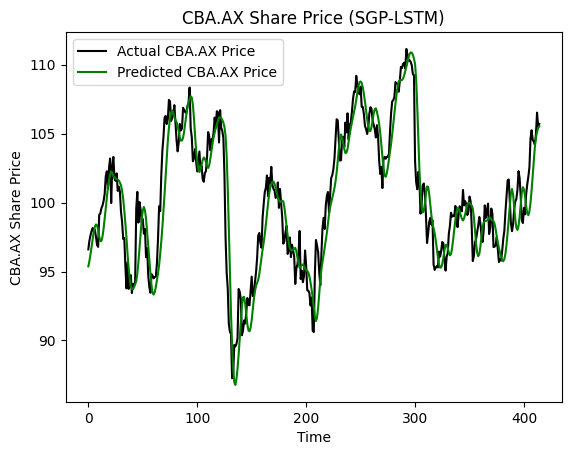

In [ ]:
enhance_y_test = scalers['Close'].inverse_transform(enhance_y_test.reshape(-1, 1))
enhance_predicted_prices = scaler.inverse_transform(enhance_predicted_prices.reshape(-1,1))

plt.plot(enhance_y_test, color="black", label=f"Actual {'CBA.AX'} Price")
plt.plot(enhance_predicted_prices, color="green", label=f"Predicted {'CBA.AX'} Price")
plt.title(f"{'CBA.AX'} Share Price (SGP-LSTM)")
plt.xlabel("Time")
plt.ylabel(f"{'CBA.AX'} Share Price")
plt.legend()
plt.show()

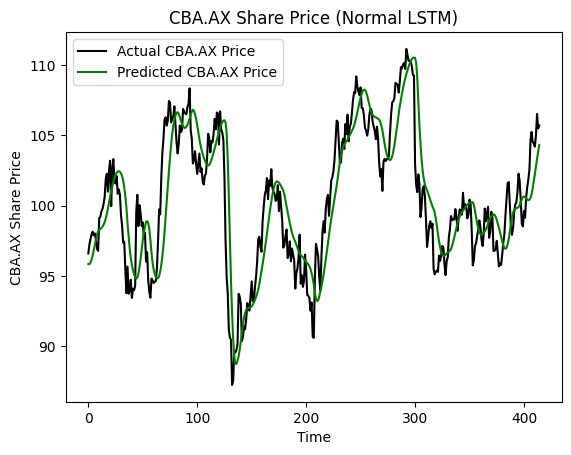

In [ ]:
y_test = scalers['Close'].inverse_transform(y_test.reshape(-1, 1))
normal_predicted_prices = scaler.inverse_transform(normal_predicted_prices.reshape(-1,1))

plt.plot(y_test, color="black", label=f"Actual {'CBA.AX'} Price")
plt.plot(normal_predicted_prices, color="green", label=f"Predicted {'CBA.AX'} Price")
plt.title(f"{'CBA.AX'} Share Price (Normal LSTM)")
plt.xlabel("Time")
plt.ylabel(f"{'CBA.AX'} Share Price")
plt.legend()
plt.show()